# Training Neural Networks with PyTorch
Copyright 2021, LEAKY.AI LLC

This is Assignment 4 for the Introduction to Deep Learning with PyTorch course (www.leaky.ai).  In this assignment you will:
- Use Google Colab to train simple neural networks using PyTorch
- Explore how different loss functions, optimizers, learning rates and other parameters affects the training process
- Plot the target output vs the actual output of the model after training

To Get Started:
1.	Open up a web browser (preferable Chrome)
2.	Copy the Project GitHub Link: https://github.com/LeakyAI/PyTorch-Overview
3.	Head over to Google Colab (https://colab.research.google.com)
4.	Load the notebook: Training and Inference - Start Here.ipynb
5.	Replace the [TBD]'s with your own code
6.	Execute the notebook after completing each cell and check your answers using the solution notebook

Hint:  Don't forget to have your PyTorch Cheatsheet handy.  You can find the latest on the home landing page of the course.

Good luck!

## Import the PyTorch Libraries and Set Random Seeds
Start by importing our PyTorch libraries, setting our random seed to get reproducible results and then verifying our PyTorch version.

In [1]:
# Import PyTorch, math and graphing libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math, random
import matplotlib.pyplot as plt

# Set our seeds to get reproducible results
torch.manual_seed(6)
random.seed(6)

## Create Synthetic Teddy Bear Sales Dataset
To begin, we will use our Teddy Bear sales data from the earlier assingment. 

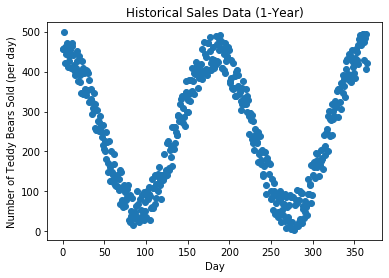

In [2]:
# Create a random synthentic sales dataset for Teddy Bear sales over 1 year
day = torch.linspace(0, 365, 500)
teddyBears = (100*(2*torch.cos(day*4*math.pi/365)+torch.rand(500))+200)

# Display our Teddy Bear sales data for year 1
plt.scatter(day, teddyBears)
plt.xlabel("Day")
plt.ylabel("Number of Teddy Bears Sold (per day)")
plt.title("Historical Sales Data (1-Year)")
plt.show()

## Normalize the Dataset
Networks train better if inputs are small (~-1..1) so we typically scale the inputs and desired output (up or down).  Two common ways to scale:
- Min Max Normalization – rescale values to a range of 0..1 using max and min values
- Standardization – rescale with 0 mean and 1 std. deviation, best if outliers

Since the dataset in this case does not have issues with significant outliers, we will simply apply normalization.

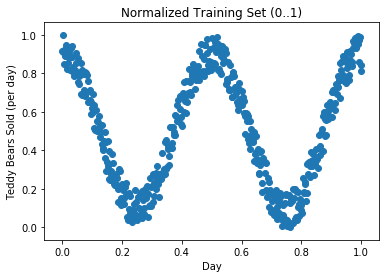

In [3]:
# Create our scale values in order to scale the inputs
# and outputs to be in the range of 0..1
scaleOutput = 500.0     # Teddy Bear Sales should be in range of 0..1
scaleInput = 365.0      # Day (input) should be in the range of [0..1]

# Prepare our normalized training set 
# Noramlized Value = (Input - Min) / (Max - Min)
dayNormalized = (day - day.min()) / (day.max()-day.min())
teddyBearsNormalized = (teddyBears - teddyBears.min()) / (teddyBears.max()-teddyBears.min())

# Display normalized values for our training data
plt.scatter(dayNormalized, teddyBearsNormalized)
plt.title("Normalized Training Set (0..1)")
plt.xlabel("Day")
plt.ylabel("Teddy Bears Sold (per day)")
plt.show() 

## Wrap Dataset in PyTorch's Dataset and Dataloader Class
PyTorch offers a Dataset class and a Dataloader class that speeds up the process of batching our data.  Below you will implement a PyTorch dataset using the Teddy Bear sales data above and then pass that to the DataLoader class which will automatically create our batches for training.

### Add a Batch Dimension
When training, our dimensions for the input data must be [batch, day] and our output target must be [batch, teddyBearsSold].  We will use the unsqueeze function to add a dimension (dim=1) to each of our tensors.

In [4]:
# Add a batch dimension
x=torch.unsqueeze(dayNormalized, dim=1)
y=torch.unsqueeze(teddyBearsNormalized,dim=1)

In [5]:
# Create the index splits for training, validation and test
import numpy as np
total = len(x)
indices = list(range(total))

# Grab 80% of the data for training, then 10% / 10% for test and validation
trainingPercent = .8
split1 = int(total*trainingPercent)
split2 = int(((total - split1)/2)+split1)
np.random.shuffle(indices)

In [6]:
# Create our a simple dataset using PyTorch dataset class
class Dataset(torch.utils.data.Dataset):
  def __init__(self, x, y):
        'Initialization'
        self.x = x
        self.y = y

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.y)

  def __getitem__(self, index):
        'Generates one sample of data'
        x=self.x[index]
        y=self.y[index]
        return x,y

# Instantiate the three datasets
train_set = Dataset(x[indices[:split1]], y[indices[:split1]])
val_set = Dataset(x[indices[split1:split2]], y[indices[split1:split2]])
test_set = Dataset(x[indices[split2:]], y[indices[split2:]])

# Create dataloaders for each dataset
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=50,
                                           shuffle=True,
                                           num_workers=0)


val_loader = torch.utils.data.DataLoader(val_set,
                                           batch_size=50,
                                           shuffle=False,
                                           num_workers=0)

test_loader = torch.utils.data.DataLoader(test_set,
                                           batch_size=50,
                                           shuffle=False,
                                           num_workers=0)

print (f"Total Number of Mini-Batches: {len(train_loader)}")
print (f"Total Size of Dataset: {len(train_loader.sampler)}")

print (f"Test - Total Number of Mini-Batches: {len(test_loader)}")
print (f"Test - Total Size of Dataset: {len(test_loader.sampler)}")

Total Number of Mini-Batches: 8
Total Size of Dataset: 400
Test - Total Number of Mini-Batches: 1
Test - Total Size of Dataset: 50


## Create Training Code and Display Model
Since we will be training multiple times, we will create a function to train our model and a function to display the model's prediction vs. our training set.

In [7]:
# calculate our validation loss and accuracy
@torch.no_grad() 
def scoreModel(model, loader, criterion):
    model.eval()
    lossTotal = 0.0
    
    for x,y in loader:
        pred = model(x)
        loss = criterion(pred, y)
        lossTotal+=loss.item()*x.size(0)
        
    lossAvg = lossTotal/len(loader.sampler)    
    return lossAvg

In [8]:
# Train the Neural Network using Mini-Batches
# Purpose:  This function will train the neural network on the
#           given training dataset for x number of epochs
# Inputs:
#    epochs:     The total number of training epochs
#    model:      The neural network definition
#    train_loader: PyTorch dataloader holding our training data
#    criterion:  Loss function used during training
#    optimizer:  Algorithm for determining weights
def train(epochs, model, train_loader, val_loader, criterion, optimizer):

    # Set the model to training mode (enable dropout, batch norm stats etc.)
    minValLoss = float('inf')
    model.train()
    
    # Train model for epochs number of epochs (full pass of training set)
    for epoch in range(epochs):
        
        # Track loss over the entire epoch
        totalLoss = 0
        for x, y in train_loader:
            
            # Perform a single forward pass with a mini-batch and calculate loss
            y_pred = model(x)    
            loss = criterion(y_pred, y) 
            totalLoss+=loss.item()*x.size(0)
            
            # Update the weights
            optimizer.zero_grad()  # Update the weights
            loss.backward()
            optimizer.step()

        # Calculate the Average Training Loss
        avgTLoss = totalLoss/len(train_loader.sampler)

        # Calculate validation loss and checkpoint model if lower
        vLoss = scoreModel(model, val_loader, criterion)
        if (minValLoss > vLoss):
          torch.save(model.state_dict(), "modelCheckpoint.pt")
          minValLoss = vLoss
                
        # Display average loss every 100 epochs
        if (epoch % 100 == 0):
            print (f"Training Loss: {totalLoss/len(train_loader.sampler):.4f}")
            print (f"Validation Loss: {vLoss:.4f}")

    return

In [9]:

# Plot the model's results after training
def displayResults(model, x, scaleInput, scaleOuput, day, teddyBears):
    
    # Set the model to evaluation mode (inference)
    model.eval()
    
    # Make a single forward pass on the inputs (x)
    pred = net(x)

    # Re-scale our output predictions (from [0..1] to [0..500])
    predScaled = pred*scaleOuput
    xScaled = x*scaleInput
    
    # Display our model (red) vs our training data
    plt.scatter(day, teddyBears)
    plt.scatter(xScaled.detach().numpy()[:], predScaled.detach().numpy()[:],color="red")
    plt.xlabel("Day")
    plt.ylabel("Teddy Bears")
    plt.show()

## Build your Model to Predict Teddy Bear Sales (Regression)
Here, start by building a model with:

- 1 input (day of the year)
- 100 units in the first hidden layer
- 1 output (number of teddy bears sold that day)

Use a relu (F.relu) activation function for the hidden layer.  Do not use an activation function on the output as this will be a regression task (predicting the number of teddy bears sold on a given day in the year).

In [15]:
# Build the simple Neural Network by extending the nn.Module class

# Use a variable to define the number of hidden units in the hidden layer
numHiddenUnits = 5

class SimpleTeddyBearModel(nn.Module):
    
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(1,numHiddenUnits)
            self.fc2 = nn.Linear(numHiddenUnits,1)
        
        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = self.fc2(x)
            return x

# Create an instance of the model and print out a model summary
net = SimpleTeddyBearModel()
torch.save(net.load_state_dict(torch.load('modelcheckpoint.pth'))

           STOP HERE

net


SimpleTeddyBearModel(
  (fc1): Linear(in_features=1, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
)

#### Expected Result:  
<pre>SimpleTeddyBearModel(
  (fc1): Linear(in_features=1, out_features=25, bias=True)
  (fc2): Linear(in_features=25, out_features=1, bias=True)
)</pre>

## Select the Criterion (loss function) and Optimizer
In order to train a neural network, we need a way to measure the loss over each iteration.  We use a loss function (criterion) to measure the output of our model vs. what the actual output we desire.  Depending on the task, you will be using a specific loss function.  In this case, the task is a regression so we will use MSELoss.  For the optimzier (algorithm used to update the weights) we will start with SGD.  Try it with a learning rate of 0.05, momentum 0.9 and nesterov set to True.

In [16]:
# Reset the model weights to the same as initialized
net.load_state_dict(torch.load('modelcheckpoint.pth'))

# Select our criterion and optimzer
criterion = torch.nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, nesterov=True)

# Train network for 500 epochs and display the result
train(500, net, train_loader, val_loader, criterion, optimizer)
displayResults(net,x,scaleInput,scaleOutput,day,teddyBears)

RuntimeError: Error(s) in loading state_dict for SimpleTeddyBearModel:
	size mismatch for fc1.weight: copying a param with shape torch.Size([100, 1]) from checkpoint, the shape in current model is torch.Size([5, 1]).
	size mismatch for fc1.bias: copying a param with shape torch.Size([100]) from checkpoint, the shape in current model is torch.Size([5]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([1, 100]) from checkpoint, the shape in current model is torch.Size([1, 5]).

#### Expected Result:  
<pre>Loss: 0.6327
Loss: 0.0832
Loss: 0.0817
Loss: 0.0766
Loss: 0.0609</pre>Note: Your loss values will differ but should decrease with each iteration and end below 0.0700 as in the example above.

## Training Part 4 - Select another Optimizer
The optimzer specifies the algorithm used to update the weights during training.   Sometimes, other optimizers will work better depending on the dataset and model.   Try to change the optimzier to adam with a learning rate of 0.01 and compare the training results with the above.


Training Loss: 0.0924
Validation Loss: 0.0963
Training Loss: 0.0049
Validation Loss: 0.0070
Training Loss: 0.0037
Validation Loss: 0.0041
Training Loss: 0.0039
Validation Loss: 0.0044
Training Loss: 0.0042
Validation Loss: 0.0058


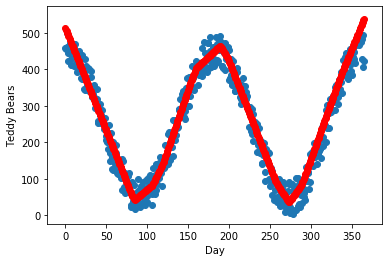

In [12]:
# Reset our weights to their original values
net.load_state_dict(torch.load('modelcheckpoint.pth'))

# Setup your training optimizer and specify your loss criteria
# Start with Adam with a learning rate of 0.01
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# Train network and display result
train(500, net, train_loader, val_loader, criterion, optimizer)
displayResults(net,x,scaleInput,scaleOutput,day,teddyBears)

#### Expected Result:  
<pre>Loss: 0.6327
Loss: 0.0757
Loss: 0.0236
Loss: 0.0043
Loss: 0.0040</pre>Note: Your loss values may differ but should decrease with each iteration and end below 0.0045 as in the example above.

### Update the Training Code to use Mini-Batches

#### Expected Result:  
<pre>Total Number of Mini-Batches: 10
Total Size of Dataset: 500</pre>

Training Loss: 0.0937
Validation Loss: 0.0791
Training Loss: 0.0046
Validation Loss: 0.0051
Training Loss: 0.0051
Validation Loss: 0.0045
Training Loss: 0.0043
Validation Loss: 0.0056
Training Loss: 0.0045
Validation Loss: 0.0065


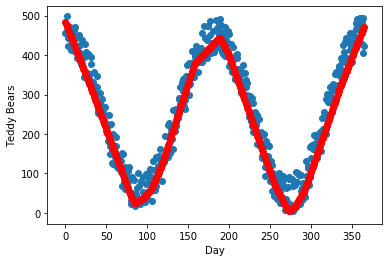

In [13]:
# Reset our weights to their original values
net.load_state_dict(torch.load('modelcheckpoint.pth'))

# Setup your training optimizer and specify your loss criteria
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# Train model using mini-batches and print out result
train(500, net, train_loader, val_loader, criterion, optimizer)
displayResults(net,x,scaleInput,scaleOutput,day,teddyBears)

### Explore Different Models and Training Parameters
Now, explore different learning rates, models and optimizers.  Start by adjusting one slightly, then another and so on.  For example, what happens when you reduce the model's hidden units below 10?  What if you add another hidden layer?   Are you able to make the predicted (red) curve fit better by adjusting other values?

Training Loss: 0.1860
Validation Loss: 0.0954
Training Loss: 0.0712
Validation Loss: 0.0585
Training Loss: 0.0724
Validation Loss: 0.0604
Training Loss: 0.0713
Validation Loss: 0.0584
Training Loss: 0.0540
Validation Loss: 0.0413


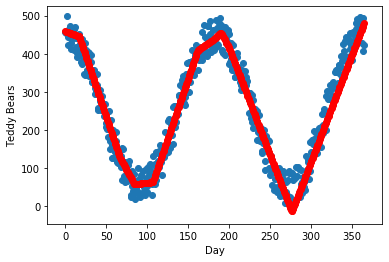

In [14]:
# Use a variable to define the number of hidden units in the hidden layer
numHiddenUnits = 15

class SimpleTeddyBearModel(nn.Module):
    
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(1,numHiddenUnits)
            self.fc2 = nn.Linear(numHiddenUnits,numHiddenUnits)
            self.fc3 = nn.Linear(numHiddenUnits,1)
        
        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return x

# Create an instance of the model and print out a model summary
net = SimpleTeddyBearModel()

# Setup your training optimizer and specify your loss criteria
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

# Train model using mini-batches and print out result
train(500, net, train_loader, val_loader, criterion, optimizer)
displayResults(net,x,scaleInput,scaleOutput,day,teddyBears)

### Key Takeaways

- You built a PyTorch deep neural network
- You trained the network and compared the ouput with the training set
- You experimented with different optimizers, learning rates and epochs

Congratulations for finishing the assingment!  

Keep it going!